In [1]:
import torch
from torch import optim
from torch import Tensor
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import random_split
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F 

from utils import *
import config
import random

from typing import Type

from Classify import Classifier
from Network_model import Generator, ConvModel

from tqdm.notebook import tqdm
import copy

In [2]:
print_config()

RANDOM_SEED   :  11042004
DATA_DIR      :    ./data
USED_DATA     :    DOODLE
NUM_LABELLED  :       100
DEVICE        :    cuda:0
EPOCHS        :        20
BATCH_SIZE    :        32
LEARNING_RATE :    0.0002
SCHED         :     False
GAN_BATCH_SIZE:       128


In [3]:
set_random_seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)

Setting seeds ...... 



In [4]:
name = "GANSSL"

In [5]:
PATH = get_PATH(name)
PATH

'DOODLE/GANSSL/_100'

In [6]:

if config.USED_DATA == "CIFAR10":
	mean = [0.5]*3
	std = [0.5]*3

	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

if config.USED_DATA == "MNIST" or config.USED_DATA == "DOODLE":
	mean = [0.5]
	std = [0.5]
	train_tfm = tt.Compose([
		tt.Resize(32),
		tt.Normalize(mean, std, inplace=True)
	])

test_tfm = tt.Compose([
	tt.Resize(32),
	tt.Normalize(mean, std)
])

In [7]:
train_ds, test_ds, classes = load_data(train_tfm, test_tfm)

In [8]:
X_full = train_ds.x
y_full = train_ds.y

In [9]:
classes

['0 - helicopter',
 '1 - car',
 '2 - book',
 '3 - windmill',
 '4 - cat',
 '5 - umbrella',
 '6 - octopus',
 '7 - bird',
 '8 - hat',
 '9 - birthday cake']

In [10]:
latent_size = 100
n_classes = len(classes)
channels = X_full.shape[1] # MNIST
n_classes, channels

(10, 1)

In [11]:
# test dataloader
test_dl = CreateDataLoader(test_ds, batch_size=config.BATCH_SIZE, device=config.DEVICE)

In [12]:
X_sup, y_sup, X_unsup, _ = supervised_samples(X_full, y_full, config.NUM_LABELLED, n_classes, get_unsup=True) # type: ignore

In [13]:
class Discriminator(nn.Module):
	def __init__(self, in_channels, n_classes) -> None:
		super().__init__()

		self.conv = ConvModel(in_channels)

		self.dropout = nn.Dropout(0.5)

		self.classifier = nn.Linear(512, n_classes)
		
	def forward(self, X: Tensor):
		out = self.conv(X)
		out = self.dropout(out)
		out = self.classifier(out)
		return out

In [14]:
def custom_function(X: Tensor):
	Z_x = torch.sum(torch.exp(X), dim=-1)
	D_x = Z_x / (Z_x+1)
	return D_x

In [15]:
class GAN:
	def __init__(self, latent_size, n_channels, n_classes, device) -> None:
		self.generator = Generator(latent_size, n_channels)
		self.discriminator = Discriminator(n_channels, n_classes)

		self.latent_size = latent_size

		self.CEloss = nn.CrossEntropyLoss()
		self.BCEloss = nn.BCELoss()

		self.n_classes = n_classes

		self.resize = tt.Resize(32)

		self.device = device

		self.to(device)

	def to(self, device):
		self.generator = self.generator.to(device)
		self.discriminator = self.discriminator.to(device)
	
	def load_dis_state_dict(self, file):
		state_dict: dict = torch.load(file)
 
		own_state = self.discriminator.state_dict()
		for name, param in state_dict.items():
			if name not in own_state:
				continue
			
			if isinstance(param, nn.Parameter):
				# backwards compatibility for serialized parameters
				param = param.data
			own_state[name].copy_(param)
	
	def load_gen_state_dict(self, file):
		self.generator.load_state_dict(torch.load(file))
	
	@torch.no_grad()
	def evaluate(self, dataloader: DeviceDataLoader):
		self.discriminator.eval()
		corrected = 0
	
		for b in dataloader:
			images, labels = b
			outs = self.discriminator.forward(images)
			_, preds = torch.max(outs, dim=1)
			outs = torch.argmax(outs, dim=1)
			corrected += torch.sum(preds == labels).item()
		
		return corrected / dataloader.num_data()

	def classifier_step(self, X, y):
		outs = self.discriminator(X)
		loss = self.CEloss(outs, y)

		return loss

	def discriminator_step(self, X: Tensor, y: Tensor):
		outs = self.discriminator(X)
		outs = custom_function(outs)
		loss = self.BCEloss(outs, y)

		return loss
	
	def discriminator_real_step(self, X):
		batch_size = X.shape[0]
		
		y_hat = torch.zeros([batch_size], device = self.device)

		loss = self.discriminator_step(X, y_hat)
		
		return loss

	
	def discriminator_fake_step(self, batch_size):
		z = torch.randn([batch_size, self.latent_size, 1, 1], device=self.device)
		fake_images = self.generator(z)

		fake_images = self.resize(fake_images)

		y_hat = torch.zeros([batch_size], device=self.device)

		loss = self.discriminator_step(fake_images, y_hat)

		return loss
	
	def generator_step(self, batch_size):
		z = torch.randn([batch_size, self.latent_size, 1, 1], device=self.device)
		fake_images = self.generator(z)

		fake_images = self.resize(fake_images)

		outs = self.discriminator(fake_images)

		outs = F.softmax(outs, dim=1)[:, -1]

		y_hat = torch.zeros([batch_size], device=self.device)

		loss = self.BCEloss(outs, y_hat)

		return loss
	
	@staticmethod
	def get_lr(optimizer: Type[optim.Optimizer]):
		for param_group in optimizer.param_groups:
			return param_group['lr']
	
	def fit(self, epochs, batch_size, batch_per_epoch, dis_lr, sup_ds: CustomDataSet, full_ds: CustomDataSet, optimizer: Type[optim.Optimizer], opt_params = {}, sched = False, PATH = ".", save = False):

		history: dict[str, list] = {'epochs': epochs, 'Loss': []}

		if sched:
			history['Learning rate'] = []

		optimizerD = optimizer(self.discriminator.parameters(), lr = dis_lr, **opt_params)

		# optimizerG = optimizer(self.generator.parameters(), lr = dis_lr, **opt_params)

		if sched:
			OneCycleLR = optim.lr_scheduler.OneCycleLR(optimizerD, dis_lr, epochs*batch_per_epoch)

		n_sup = len(sup_ds)
		n_data = len(full_ds)


		for epoch in range(epochs):
			self.discriminator.train()

			lrs = []

			print(f"Epoch [{epoch}]:")
			for i in tqdm(range(batch_per_epoch)):
				sup_images, labels = random_split(sup_ds, [batch_size, n_sup-batch_size])[0][:]
				C_loss = self.classifier_step(sup_images.to(self.device), labels.to(self.device)) 


				unsup_images, _ = random_split(full_ds, [batch_size, n_data-batch_size])[0][:]
				real_loss = self.discriminator_real_step(unsup_images.to(self.device))
				fake_loss = self.discriminator_fake_step(batch_size)
				D_loss = (real_loss + fake_loss)/2

				loss = C_loss + D_loss
				loss.backward()

				optimizerD.step()

				lrs.append(self.get_lr(optimizerD))

				# G_loss = self.generator_step(batch_size)
				# G_loss.backward()
				# optimizerG.step()

				history['Loss'].append(C_loss.item())

				s = f'C_Loss: {C_loss:.5f}, D_Loss: {D_loss:.5f}'
				
				if sched:
					OneCycleLR.step()
					s += f', lrs: {lrs[0]:.6f}-> {lrs[-1]:.6f}'

				tqdm.write(s, end = "\r")

			tqdm.write("")

			if sched:
				history['Learning rate'] += lrs


			if save:
				torch.save(self.discriminator.state_dict(), PATH)
				
		return history

In [16]:
GANSSL = GAN(latent_size, channels, n_classes, config.DEVICE)

In [17]:
GANSSL.load_gen_state_dict(f'DCGAN/{config.USED_DATA}/netG_epoch_009.pt')
# GANSSL.discriminator.load_state_dict(torch.load("MNIST/CNN/_100.pt"))

In [18]:
sup_ds = CustomDataSet(X_sup, y_sup, train_tfm)
full_ds = CustomDataSet(X_full, y_full, train_tfm)

In [19]:
history = GANSSL.fit(20, 64, 100, 0.00001, sup_ds, full_ds, optim.RMSprop, sched = config.SCHED, PATH=PATH+".pt", save=True)

Epoch [0]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.17001, D_Loss: 0.15386
Epoch [1]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.07303, D_Loss: 0.03276
Epoch [2]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.05863, D_Loss: 0.00995
Epoch [3]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.01853, D_Loss: 0.00314
Epoch [4]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.01126, D_Loss: 0.00140
Epoch [5]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00630, D_Loss: 0.00042
Epoch [6]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.01314, D_Loss: 0.00017
Epoch [7]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00792, D_Loss: 0.00009
Epoch [8]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00489, D_Loss: 0.00003
Epoch [9]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00590, D_Loss: 0.00001
Epoch [10]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00396, D_Loss: 0.00001
Epoch [11]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00654, D_Loss: 0.00000
Epoch [12]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00612, D_Loss: 0.00000
Epoch [13]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.01153, D_Loss: 0.00000
Epoch [14]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00556, D_Loss: 0.00000
Epoch [15]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00358, D_Loss: 0.00000
Epoch [16]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00362, D_Loss: 0.00000
Epoch [17]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00452, D_Loss: 0.00000
Epoch [18]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00728, D_Loss: 0.00000
Epoch [19]:


  0%|          | 0/100 [00:00<?, ?it/s]

C_Loss: 0.00447, D_Loss: 0.00000


In [20]:
d = Discriminator(channels, n_classes).to(config.DEVICE)
d.load_state_dict(torch.load(f"{config.USED_DATA}/CNN/_{config.NUM_LABELLED}.pt"))
d.eval()
corrected = 0

for b in test_dl:
	images, labels = b
	outs = d.forward(images)
	_, preds = torch.max(outs, dim=1)
	outs = torch.argmax(outs, dim=1)
	corrected += torch.sum(preds == labels).item()

corrected / test_dl.num_data(), GANSSL.evaluate(test_dl)

(0.6096, 0.6263)

In [21]:
import pickle

In [22]:
with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)

In [23]:
with open(PATH + ".pickle", 'rb') as f:
	history = pickle.load(f)

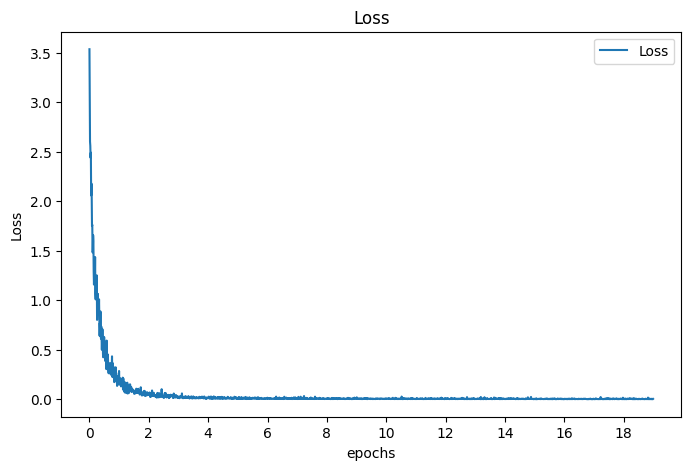

In [24]:
plotting(history)